# Digital Image Processing
## Skin Cancer Detection (PH2 dataset)
## By:2023-SE-27

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os

project_path = '/content/drive/MyDrive/Project/PH2Dataset'
dataset_path = os.path.join(project_path, 'PH2Dataset')
images_root  = os.path.join(dataset_path, 'PH2 Dataset images')

print(os.listdir(images_root)[:5])



['IMD003', 'IMD004', 'IMD008', 'IMD010', 'IMD009']


In [5]:
sample_folder = sorted(os.listdir(images_root))[1]   # e.g. IMD002
sample_path = os.path.join(images_root, sample_folder)

print("Inside IMD folder:", os.listdir(sample_path))



Inside IMD folder: ['IMD003_lesion', 'IMD003_roi', 'IMD003_Dermoscopic_Image']


In [6]:
dermo_folder = [f for f in os.listdir(sample_path) if 'Dermoscopic' in f][0]
dermo_path = os.path.join(sample_path, dermo_folder)

print("Dermoscopic folder:", dermo_folder)
print("Files:", os.listdir(dermo_path))



Dermoscopic folder: IMD003_Dermoscopic_Image
Files: ['IMD003.bmp']


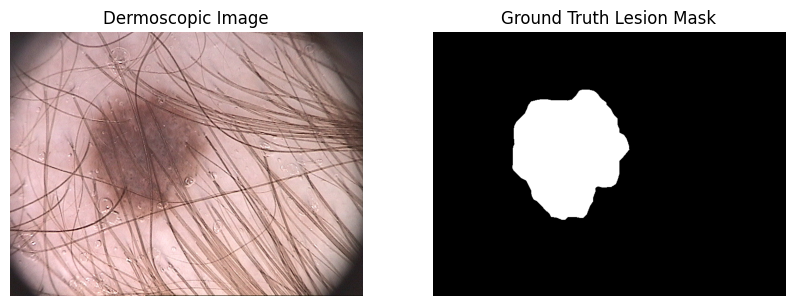

In [7]:
import os
import cv2
import matplotlib.pyplot as plt

# ---- Paths (DO NOT CHANGE) ----
project_path = '/content/drive/MyDrive/Project/PH2Dataset'
dataset_path = os.path.join(project_path, 'PH2Dataset')
images_root  = os.path.join(dataset_path, 'PH2 Dataset images')

# ---- Select any image folder (e.g., IMD002) ----
imd_folder = sorted(os.listdir(images_root))[1]   # you can change index
imd_path = os.path.join(images_root, imd_folder)

# ---- Dermoscopic image ----
dermo_folder = [f for f in os.listdir(imd_path) if 'Dermoscopic' in f][0]
dermo_path = os.path.join(imd_path, dermo_folder)
dermo_image_file = os.listdir(dermo_path)[0]

dermo_img = cv2.imread(os.path.join(dermo_path, dermo_image_file))
dermo_img = cv2.cvtColor(dermo_img, cv2.COLOR_BGR2RGB)

# ---- Lesion mask ----
lesion_folder = [f for f in os.listdir(imd_path) if 'lesion' in f.lower()][0]
lesion_path = os.path.join(imd_path, lesion_folder)
lesion_mask_file = os.listdir(lesion_path)[0]

lesion_mask = cv2.imread(os.path.join(lesion_path, lesion_mask_file), 0)

# ---- Display side by side ----
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(dermo_img)
plt.title("Dermoscopic Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(lesion_mask, cmap='gray')
plt.title("Ground Truth Lesion Mask")
plt.axis('off')

plt.show()


# task 2

In [12]:
# GENERATE CORRECT MASKS
import os
import cv2
import numpy as np

project_path = "/content/drive/MyDrive/Project/PH2Dataset"
images_root = os.path.join(project_path, "PH2Dataset", "PH2 Dataset images")
mask_save_path = os.path.join(project_path, "Generated_Masks")

os.makedirs(mask_save_path, exist_ok=True)

for imd in sorted(os.listdir(images_root)):
    img_path = os.path.join(images_root, imd, f"{imd}_Dermoscopic_Image", f"{imd}.bmp")

    img = cv2.imread(img_path)
    img = cv2.resize(img, (256,256))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)

    # OTSU (lesion becomes WHITE)
    ret, mask = cv2.threshold(
        blurred, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    cv2.imwrite(os.path.join(mask_save_path, imd + ".png"), mask)

print("✅ Task 1 complete: Correct masks generated")

✅ Task 1 complete: Correct masks generated


In [13]:
# SEGMENT IMAGES USING MASKS
segmented_path = os.path.join(project_path, "Segmented_Images")
os.makedirs(segmented_path, exist_ok=True)

for imd in sorted(os.listdir(images_root)):
    img_path = os.path.join(images_root, imd, f"{imd}_Dermoscopic_Image", f"{imd}.bmp")
    mask_path = os.path.join(mask_save_path, imd + ".png")

    img = cv2.imread(img_path)
    img = cv2.resize(img, (256,256))
    mask = cv2.imread(mask_path, 0)

    segmented = cv2.bitwise_and(img, img, mask=mask)

    cv2.imwrite(os.path.join(segmented_path, imd + ".png"), segmented)

print("✅ Task 2 complete: Segmented images created")


✅ Task 2 complete: Segmented images created


In [47]:
import os
import cv2
import numpy as np
import pandas as pd

project_path = "/content/drive/MyDrive/Project/PH2Dataset"
segmented_path = os.path.join(project_path, "Segmented_Images")

features = []

for file in sorted(os.listdir(segmented_path)):
    img_path = os.path.join(segmented_path, file)
    img = cv2.imread(img_path)

    if img is None:
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lesion_pixels = gray[gray > 0]

    if len(lesion_pixels) < 100:
        continue

    row = {
        "Image_Name": file.replace(".png", ""),
        "Mean_Intensity": np.mean(lesion_pixels),
        "Std_Intensity": np.std(lesion_pixels),
        "Area": len(lesion_pixels),
        "R_Mean": np.mean(img[:,:,0][gray > 0]),
        "G_Mean": np.mean(img[:,:,1][gray > 0]),
        "B_Mean": np.mean(img[:,:,2][gray > 0]),
    }

    features.append(row)

df = pd.DataFrame(features)

# --- Start of fix: Load and merge target labels ---
ph2_meta_path = os.path.join(project_path, "PH2Dataset", "PH2_dataset.txt")

parsed_meta_data = []
with open(ph2_meta_path, 'r') as f:
    # Skip the header line
    next(f)
    for line in f:
        parts = line.strip().split('||')
        if len(parts) > 3: # Ensure enough parts exist
            image_id = parts[1].strip()
            diagnosis = parts[3].strip()
            parsed_meta_data.append({'Image_ID': image_id, 'Diagnosis': diagnosis})

meta_df = pd.DataFrame(parsed_meta_data)

# Image_Name is already clean from splitting and stripping
meta_df['Image_Name'] = meta_df['Image_ID']

# Debugging step: print unique values of Diagnosis before mapping
print("Unique Diagnosis values from meta_df:", meta_df['Diagnosis'].unique())

# Define mapping for diagnosis to numerical target
# Assuming 'Melanoma' is 1 (malignant) and others are 0 (benign/non-malignant)
diagnosis_map = {
    'Common Nevus': 0,
    'Atypical Nevus': 0,
    'Melanoma': 1,
    '0': 0, # Map '0' to 0 (benign)
    '1': 1,  # Map '1' to 1 (malignant)
    '2': 0   # Map '2' to 0 (benign, based on common interpretation of PH2 dataset)
}

meta_df['Target'] = meta_df['Diagnosis'].map(diagnosis_map)

# Merge features DataFrame with target labels
df = pd.merge(df, meta_df[['Image_Name', 'Target']], on='Image_Name', how='left')
# --- End of fix ---

save_path = os.path.join(project_path, "Feature_Extracted.xlsx")
df.to_excel(save_path, index=False)

print(" Feature_Extracted.xlsx created with populated Target column")
print(df.head())

Unique Diagnosis values from meta_df: ['0' '1' '2']
 Feature_Extracted.xlsx created with populated Target column
  Image_Name  Mean_Intensity  Std_Intensity   Area     R_Mean      G_Mean  \
0     IMD002       92.474696      22.688562  20491  56.578059   79.930506   
1     IMD003      102.052689      32.970697  17423  90.064340   93.708718   
2     IMD004      103.628195      31.251869  18117  87.326434   93.087045   
3     IMD006      108.227250      27.451862  12132  82.464392   98.707550   
4     IMD008      114.532063      32.223080   8187  91.391719  108.132405   

       B_Mean  Target  
0  130.783612       1  
1  122.998737       0  
2  130.527350       1  
3  136.738625       1  
4  135.918285       1  


In [36]:
print(project_path)
print(os.path.exists(project_path))


/content/drive/MyDrive/Project/PH2Dataset
True


In [37]:
print("Files inside project folder:")
print(os.listdir(project_path))


Files inside project folder:
['PH2Dataset', 'Generated_Masks', 'Segmented_Images', 'Feature_Extracted.xlsx']


In [38]:
import pandas as pd
df=pd.read_excel(os.path.join(project_path, "Feature_Extracted.xlsx"))

In [39]:
df

,Image_Name,Mean_Intensity,Std_Intensity,Area,R_Mean,G_Mean,B_Mean,Target
0,IMD002,92.474696,22.688562,20491,56.578059,79.930506,130.783612,NaN
1,IMD003,102.052689,32.970697,17423,90.064340,93.708718,122.998737,NaN
2,IMD004,103.628195,31.251869,18117,87.326434,93.087045,130.527350,NaN
3,IMD006,108.227250,27.451862,12132,82.464392,98.707550,136.738625,NaN
4,IMD008,114.532063,32.223080,8187,91.391719,108.132405,135.918285,NaN
...,...,...,...,...,...,...,...,...
195,IMD433,126.746960,29.361869,10856,85.956245,114.058401,167.211404,NaN
196,IMD434,106.470357,22.518460,14759,93.620774,93.741852,136.355309,NaN
197,IMD435,132.792167,24.511087,31583,121.481715,114.151411,173.660862,NaN
198,IMD436,130.802825,24.496490,32783,84.688802,116.219809,177.009029,NaN


# Training Random Forest Model

In [40]:
# IMPORT LIBRARIES


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

In [41]:
# LOAD FEATURE DATASET
project_path = "/content/drive/MyDrive/Project/PH2Dataset"

df = pd.read_excel(project_path + "/Feature_Extracted.xlsx")

print(df.shape)
print(df.head())

(200, 8)
  Image_Name  Mean_Intensity  Std_Intensity   Area     R_Mean      G_Mean  \
0     IMD002       92.474696      22.688562  20491  56.578059   79.930506   
1     IMD003      102.052689      32.970697  17423  90.064340   93.708718   
2     IMD004      103.628195      31.251869  18117  87.326434   93.087045   
3     IMD006      108.227250      27.451862  12132  82.464392   98.707550   
4     IMD008      114.532063      32.223080   8187  91.391719  108.132405   

       B_Mean  Target  
0  130.783612     NaN  
1  122.998737     NaN  
2  130.527350     NaN  
3  136.738625     NaN  
4  135.918285     NaN  


In [42]:
# SPLIT FEATURES & TARGET
X = df.drop(columns=['Image_Name', 'Target'])
y = df['Target']

In [49]:
# TRAIN-TEST SPLIT (80-20)
# Ensure df has no NaNs in 'Target' before splitting
df.dropna(subset=['Target'], inplace=True)
X = df.drop(columns=['Image_Name', 'Target'])
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [50]:
# TRAIN RANDOM FOREST
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [51]:
# PREDICTION
y_pred = model.predict(X_test)

In [52]:
# CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[26  4]
 [11  9]]


In [53]:
# EVALUATION METRICS
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)   # Recall of class 1 (melanoma)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print("Accuracy:", accuracy)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

Accuracy: 0.7
Sensitivity (Recall): 0.45
Specificity: 0.8666666666666667
